# PCA Projection of SOAP Environments

This notebook is intended as an introductory how-to on projecting SOAP vectors along their principal components. For more information on the variable conventions, derivation, utility, and calculation of SOAP vectors, please refer to (among others):

<ul>
  <li> <a href="https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.184115">On representing chemical environments (Bartók 2013)</a></li>
  <li><a href="https://onlinelibrary.wiley.com/doi/full/10.1002/qua.24927">Gaussian approximation potentials: A brief tutorial introduction (Bartók 2015)</li>
  <li><a href="https://pubs.rsc.org/en/content/articlepdf/2016/cp/c6cp00415f">Comparing molecules and solids across structural and alchemical space (De 2016)</li>
    <li><a href="https://link.springer.com/content/pdf/10.1007%2F978-3-319-42913-7_68-1.pdf">Machine Learning of Atomic-Scale Properties Based on Physical Principles (Ceriotti 2018)</li>
</ul>

Beyond libRascal, the packages used in this tutorial are:  [json](https://docs.python.org/2/library/json.html), [numpy](https://numpy.org/), [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/), [matplotlib](https://matplotlib.org/), and [ase](https://wiki.fysik.dtu.dk/ase/index.html).

In [1]:
%matplotlib inline

# may omit in final version
%reload_ext autoreload
%autoreload 2 

import os
import time
import sys

import numpy as np
import ase
from ase.io import read
from matplotlib import pyplot as plt
import json
from sklearn.decomposition import KernelPCA

wd=!(pwd)
sys.path.append(f'{wd[0]}/utilities')

if('/docs/source/tutorials' in wd[0]):
    ref_dir = '../../../reference_data'
else:
    ref_dir = '../reference_data'
    
from general_utils import *
from rascal.representations import SphericalInvariants as SOAP
from rascal.models import Kernel

## Training a Kernel PCA on Global Properties
As discussed in [Link to Hyperparameter Tutorial](), the hyperparameters of a SOAP descriptor will decide the amount of information contained in the descriptor. Here we'll use a standard Power Spectrum SOAP representation:

### Hyperparameters

In [2]:
hyperparameters = dict(soap_type = 'PowerSpectrum', \
                       interaction_cutoff = 3.5, \
                       max_radial = 6, \
                       max_angular = 6, \
                       gaussian_sigma_constant = 0.4, \
                       gaussian_sigma_type = 'Constant', \
                       cutoff_smooth_width = 0.5
                      )

### Load and Read the Input File
We'll first look at the [small_molecules-1000.xyz]() file, which contains the per-atom formation energy in eV. Because this is a property of the crystal (opposed to the atoms), we'll want to use the "Structure" kernel given by libRascal.

In [29]:
# input_file = f'{ref_dir}/inputs/CSD-500.xyz'
# property_name = "CS"
input_file = '/local/scratch/cersonsk/gch_sandbox/molecules_project/total.xyz'

We then read the trajectory, store the desired property, and create our SOAP calculator.

In [52]:
frames = np.array(read(input_file,":"))
number_of_frames = len(frames)
# property_values = np.array([cc.arrays[property_name] for cc in frames])
print(f"There are {number_of_frames} frames.")#" and {len(np.concatenate(property_values))} environments.")

representation = SOAP(**hyperparameters)

There are 21415 frames.


In [53]:
constituents = np.array([''.join(list(sorted(set(frame.symbols)))) for frame in frames])
const_id = {x: i for i,x in enumerate(list(sorted(set(constituents))))}
const_ids = np.array([const_id[c] for c in constituents])

### Preparing Data for KPCA

We also need to define a few parameters for our training model:
<ul>
  <li> <b>training percentage</b>: (float) percent of frames to train the model on</li>
  <li> <b>$\zeta$</b>: (int) order the dot kernel</li>
  <li> <b>kernel_type</b>: (string, "Atom" or "Structure") whether to compare the environmental or average features.
</ul>

We also need to split our dataset into a [training and testing set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).

In [64]:
training_percentage = 0.8
n_subset = 500
zeta = 2
kernel_type = "Structure"

In [65]:
def split_dataset(N, max_N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(max_N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):N]

train_idx, test_idx = split_dataset(n_subset, number_of_frames, training_percentage)

Now we're ready to train the model! We can use our SOAP calculator to compute the features of our training set.

In [66]:
training_features = representation.transform(frames[train_idx])
testing_features = representation.transform(frames[test_idx])
len(train_idx), len(test_idx)

(400, 100)

### Constructing the KRR and Predicting the Properties

We'll construct a KRR object so that we can reuse the model.

### Constructing the Kernel
libRascal provides different kernels through the rascal.models.Kernel class.

Here we'll use the cosine kernel, which uses the $\zeta$ parameter we defined earlier. The cosine kernel is defined as:

\begin{equation}
k(x, y) = \left(\frac{xy^T}{||x|| ||y||}\right)^\zeta
\end{equation}

A Kernel object can be called on a single feature (to give the self-kernel) or a pair of features.

In [67]:
kernel = Kernel(representation=representation, name="Cosine",
                 target_type=kernel_type, zeta=2)
K_train = kernel(training_features, training_features)
K_test = kernel(testing_features, training_features)

In [68]:
K_train.shape, K_test.shape

((400, 400), (100, 400))

### Training the KPCA

In [69]:
n_KPCA = 2

In [70]:
v, U = np.linalg.eigh(K_train)

# sort in decreasing order
v = np.flip(v, axis=0)
U = np.flip(U, axis=1)
U = U[:, v > 0]
v = v[v > 0]

proj = np.matmul(U[:,:n_KPCA], np.diagflat(1.0/np.sqrt(v[0:n_KPCA])))
proj.shape

(400, 2)

In [71]:
T_train = np.matmul(K_train, proj)
T_test = np.matmul(K_test, proj)

In [72]:
T_train.shape, T_test.shape

((400, 2), (100, 2))

### Projecting the KPCA

Text(0, 0.5, 'Principal Component 2')

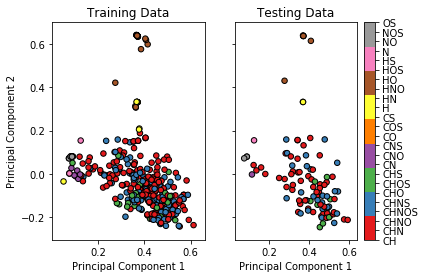

In [73]:
scatter_params = dict(s=30, edgecolor='k', cmap='Set1')

fig, axes = plt.subplots(1,2,sharey=True)

p=axes[0].scatter(T_train[:,0],T_train[:,1],
                c=const_ids[train_idx], 
                **scatter_params)
axes[1].scatter(T_test[:,0],T_test[:,1],
                c=const_ids[test_idx], 
                **scatter_params)

cbar = plt.colorbar(p)
cbar.set_ticks(range(len(const_id.keys())))
cbar.set_ticklabels(list(const_id.keys()))
axes[0].set_title("Training Data")
axes[1].set_title("Testing Data")

axes[0].set_xlabel("Principal Component 1")
axes[1].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")